# 시계열 분석(정석)

ACF plot과 PACF plot을 통해 모수를 추정하여 차분을 수행하여 분석하는 방법

## 분석 프로세스!!

1. ADF test : 정상성 테스트
- 통계적으로 귀무가설의 기각여부를 확인하는 방법

2. 정상성을 만족하지 않는다면 차분 수행

3. 차분 수행 후, 다시 ADF test
- p-value 0.05보다 작아질 때까지 수행한다.

4. ACF, PACF 검정 : 
- 상관관계를 도표를 통해 확인해봄으로서 정상성 만족여부를 파악
- ACF, PACF Plot으로 적용할 모델을 결정 (AR 또는 MA) -> p,q 값 결정

5. ARIMA 분석수행
- ARIMA 이용하여 학습값 생성 (*auto arima는 자동으로 알아서 생성)
- 예측값 생성
- 원본, 학습값과 예측값 비교

*************

## #01. 작업준비

### 패키지 참조

`pmdarima` 패키지의 설치가 필요하다.

In [22]:
from pandas import read_excel
from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#  정상성을 만족하는지 여부 판단
from statsmodels.tsa.stattools import adfuller
#시계열 분석 모듈 
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

import seaborn as sb
import sys

### 데이터 가져오기

In [23]:
df = read_excel("https://data.hossam.kr/E06/air_passengers.xlsx")
df

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


## #02. 데이터의 정상성 확인

### 그래프 초기화

In [24]:
plt.rcParams['font.family'] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10,7)
plt.rcParams['axes.unicode_minus'] = False

### 데이터 시각화

데이터의 패턴은 보이지만 비정상성임을 알 수 있다.

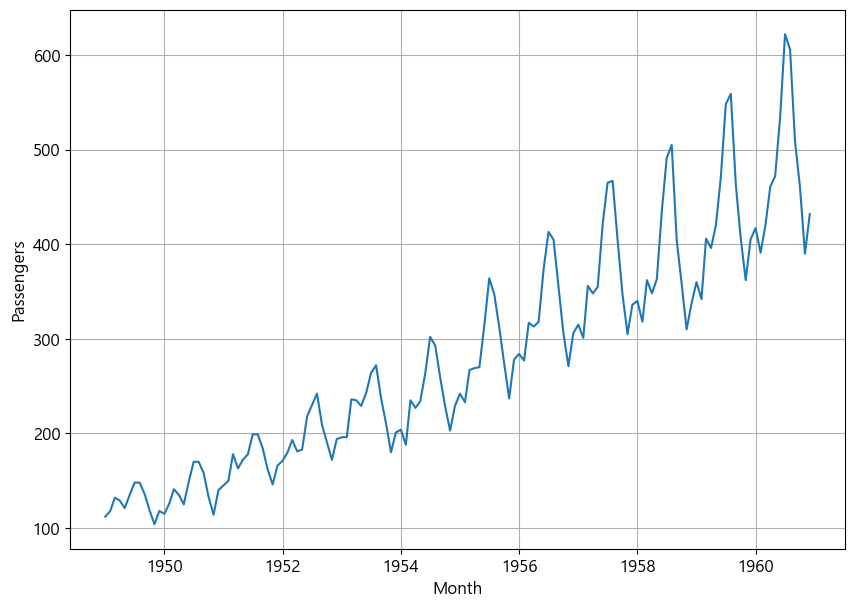

In [25]:
plt.figure()
sb.lineplot(data=df, y='Passengers', x='Month')
plt.grid()
plt.show()
plt.close()

### 원본 데이터에 대한 `ADF 테스트`

ACF, PACF Plot으로 적용할 모델을 결정한다면 차분을 몇 번 수행하는 것이 좋을지 결정해야 한다.

|모델|의미|
|---|---|
| $AR(n)$ | $ARIMA(p,d,q)$ 중에서 $p=n, q=0$이라는 의미|
| $MA(n)$ | $ARIMA(p,d,q)$ 중에서 $p=0, q=n$이라는 의미|

ADF 테스트의 결과로 차분의 횟수가 결정되면 이 값이 $d$를 의미함.

#### ADF 테스트의 가설

ADF Test : 시계열이 안정적인지 여부를 확인하는데 이용되는 방법 

|가설|내용|
|--|--|
|귀무가설|데이터가 정상성과 다르다(=비정상성임을 의미)|
|대립가설|데이터가 정상성이다|

In [ ]:
ar = adfuller(df)

print('ADF Statistic : %f' % ar[0])
print('p-value : %f' % ar[1])
print('num of lags : %f' % ar[2])
print('num of observations : %f' % ar[3])
print('Critical Values: ')
for key, value in ar[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic : -4.090230
p-value : 0.001005
num of lags : 0.000000
num of observations : 41.000000
Critical Values: 
	1%: -3.601
	5%: -2.935
	10%: -2.606


p-value가 0.05보다 작으므로 귀무가설을 기각하고 대립가설 채택. 즉, 예제 데이터는 정상성 데이터

만약 귀무가설이 채택되어 정상성이 아니라고 판단될 경우 차분을 1회 수행하고 다시 ADF 검정을 수행

대립가설이 채택될때까지 이 과정을 반복함

반복횟수가 $d$값이 됨

> 이 예제에서는 1번의 차분은 수행해야 한다고 가정함

###  `1차 차분 수행`

날짜 데이터는 평균을 낼 수 없기 떄문에 실 데이터만으로 차분을 수행해야 한다. 

In [26]:
diff = df['Passengers'].diff().dropna()
diff

1       6.0
2      14.0
3      -3.0
4      -8.0
5      14.0
       ... 
139   -16.0
140   -98.0
141   -47.0
142   -71.0
143    42.0
Name: Passengers, Length: 143, dtype: float64

### 차분 결과 시각화

평균은 0으로 일정해지는 것으로 보이나 뒤로 갈수록 점점 간격이 커지는 것으로 보아 아직 분산은 일정하지 않는 것으로 여겨짐

즉, 아직은 정상성을 갖는다고 보기 어렵다.

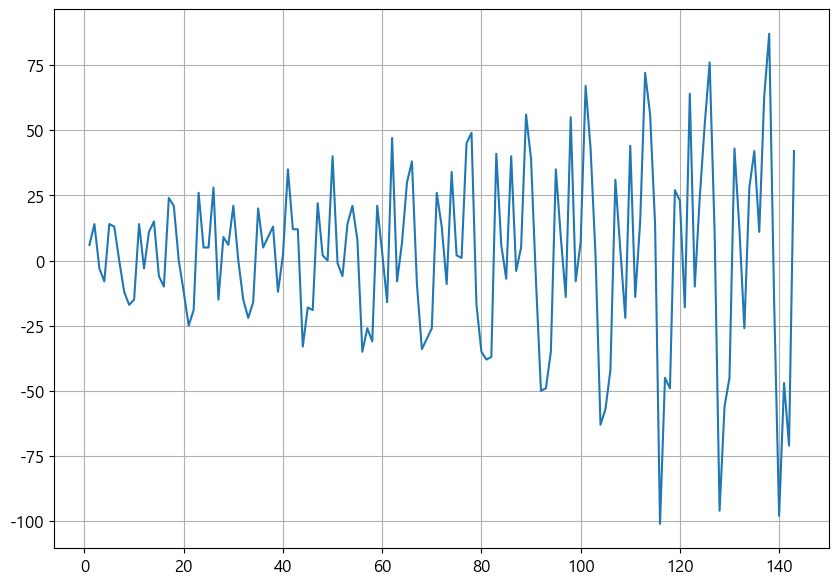

In [27]:
plt.figure()
sb.lineplot(x=diff.index, y=diff.values)
plt.grid()
plt.show()
plt.close()

### `차분 결과에 대한 ADF 테스트`
P-value 가 아직은 0.05보다 크므로 정상성을 만족하지 않지만 1회 정도 추가로 차분을 수행하면 정상성 데이터 변환이 가능할 것으로 예상됨 (여기서는 생략)

In [28]:
ar = adfuller(diff.values)

print('ADF Statistic : %f' % ar[0])
print('p-value : %f' % ar[1])
print('num of lags : %f' % ar[2])
print('num of observations : %f' % ar[3])
print('Critical Values: ')
for key, value in ar[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic : -2.829267
p-value : 0.054213
num of lags : 12.000000
num of observations : 130.000000
Critical Values: 
	1%: -3.482
	5%: -2.884
	10%: -2.579


## #03. ACF, PACF 검정

정상 시계열 데이터의 경우, ACF는 상대적으로 빠르게 0(상관관계 0)을 접근한다. 

비정상 시계열 데이터의 경우, ACF는 천천히 감소하며 종종 큰 양의 값을 갖는다.

|구분| $AR(p)$ 모델 적합 | $MA(q)$ 모델 적합|
|---|------------|------------|
|ACF plot | 천천히 감소 | 첫 값으로부터 $q$개 뒤에 끊긴다 |
|PACF plot| 첫 값으로부터 $p$개 뒤에 끊긴다 | 천천히 감소

천천히 감소 = 안정적이다

### ACF Plot

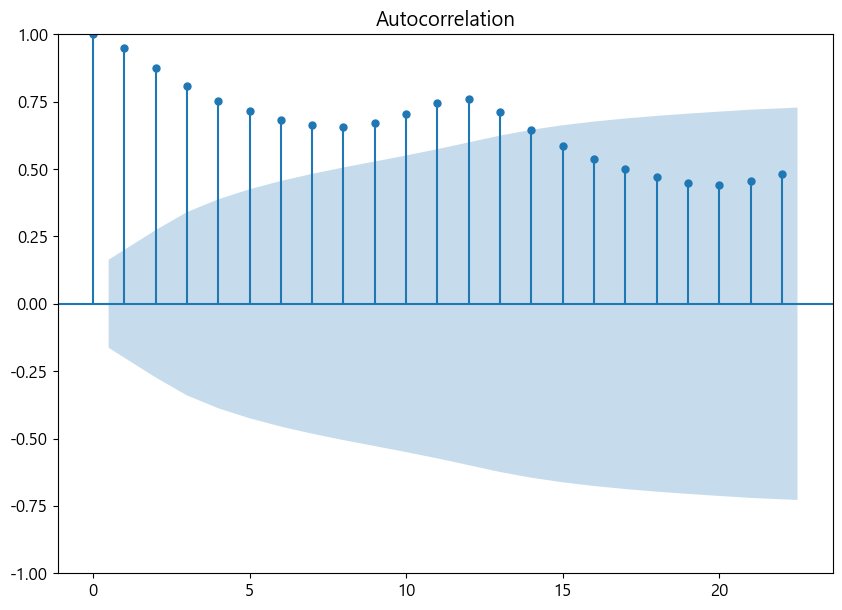

In [29]:
plot_acf(df['Passengers'])
plt.show()
plt.close()

0으로 수렴해야한다..

### PACF Plot

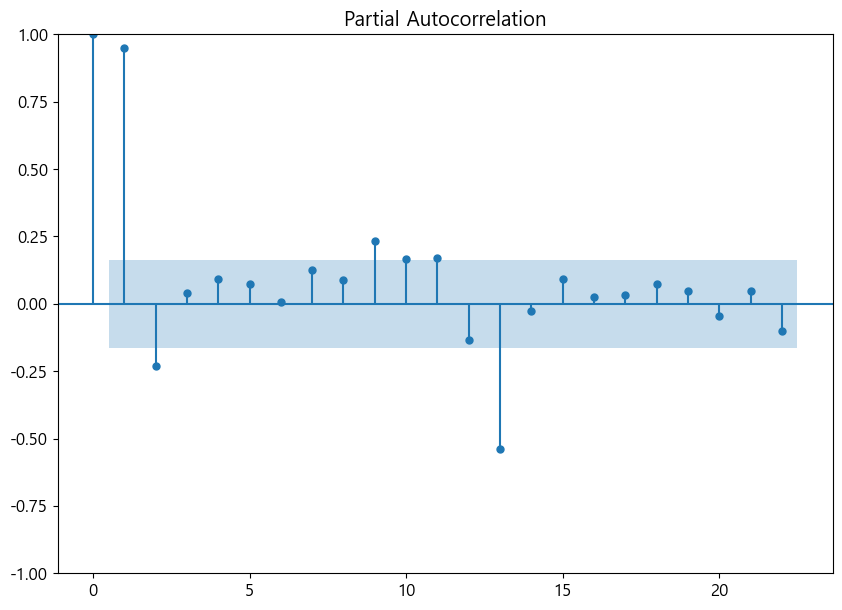

In [30]:
plot_pacf(df['Passengers'])
plt.show()
plt.close()

### 결과 판정

|구분|ACF plot|PACF plot|
|---|----|---|
|감소|상대적으로 완만|상대적으로 급격|
|파란박스 진입 지점|$p$ = 1| $q$ = 1|

이 결과를 고려하여 완만함을 보이는 ACF 플롯을 채택

AR(1) 모델로 결정

p-value가 0.05보다 작으므로 귀무가설을 기각하고 대립가설 채택. 즉, 예제 데이터는 정상성 데이터

만약 귀무가설이 채택되어 정상성이 아니라고 판단될 경우 차분을 1회 수행하고 다시 ADF 검정을 수행

## #03. ARIMA 분석 수행

- transformed : Whether or not start_params is already transformed. Default is True

In [31]:
model = ARIMA(df['Passengers'], order=(1,1,0)) # 차분한 데이터 x 원본데이터 O
fit = model.fit() # model.fit(transformed=True) : default
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -698.926
Date:                Thu, 03 Aug 2023   AIC                           1401.852
Time:                        12:02:31   BIC                           1407.778
Sample:                             0   HQIC                          1404.260
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3066      0.080      3.849      0.000       0.150       0.463
sigma2      1029.2429    103.738      9.922      0.000     825.920    1232.566
Ljung-Box (L1) (Q):                   0.66   Jarque-

### 학습결과에 대한 예측값 산정

In [34]:
start_index = 0
end_index = len(df['Passengers']) + 10 #+10만큼 예측할 것.
pd = fit.predict(start=start_index, end=end_index)
pd

0        0.000000
1      112.038959
2      119.839303
3      136.291707
4      128.080349
          ...    
150    450.562051
151    450.565327
152    450.566331
153    450.566639
154    450.566733
Name: predicted_mean, Length: 155, dtype: float64

### 이후 10단계의 예측값 생성

In [35]:
fc = fit.forecast(10)
fc

144    444.875121
145    448.821995
146    450.031912
147    450.402812
148    450.516512
149    450.551367
150    450.562051
151    450.565327
152    450.566331
153    450.566639
Name: predicted_mean, dtype: float64

### 관측치와 예측치의 비교 결과 시각화

In [36]:
x = list(range(0, len(df), 20))
x

[0, 20, 40, 60, 80, 100, 120, 140]

In [39]:
xlabels = []

for i in x:
    xlabels.append(df.loc[i, 'Month'].strftime('%Y-%m-%d'))

xlabels

['1949-01-01',
 '1950-09-01',
 '1952-05-01',
 '1954-01-01',
 '1955-09-01',
 '1957-05-01',
 '1959-01-01',
 '1960-09-01']

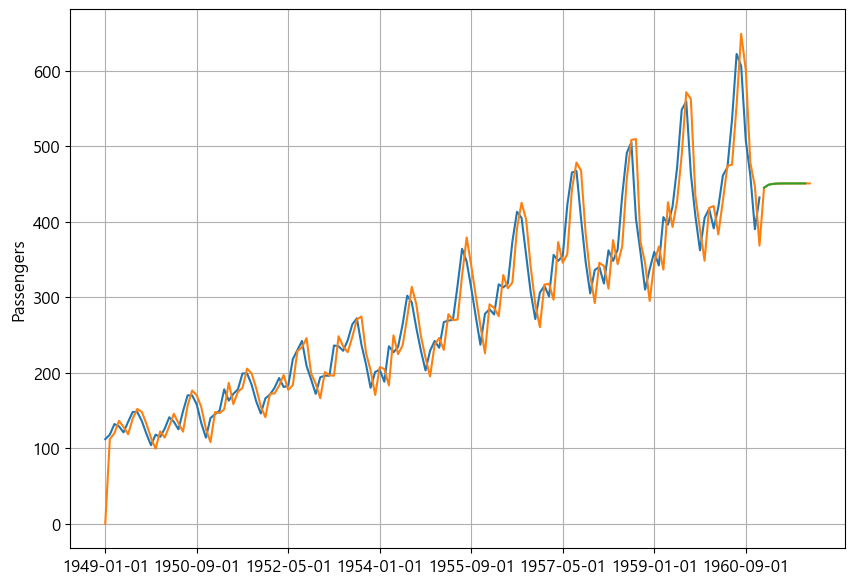

In [40]:
plt.figure()
sb.lineplot(x=df.index, y=df['Passengers']) #원본
sb.lineplot(x=pd.index, y=pd) #원본을 토대로 학습하여 예측한 값
sb.lineplot(x=fc.index, y=fc) #이후 10단계를 예측한 값

plt.xticks(x, xlabels, rotation=0)

plt.grid()
plt.show()
plt.close()

## #05. Auto ARIMA

최적의 ARIMA 모델을 자동으로 찾아서 검색을 수행해 주는 기능

### 원본 데이터에 대한 분석 수행

예제 데이터에서는 파라미터를 변경하여 수행한 결과와 기본값만으로 수행한 결과가 동일하였다.

In [41]:
model = auto_arima(x=df['Passengers'],
                   y=df['Month'],
                   d=1,                         #차분횟수(default=1)
                   start_p=1,                   #default = 2
                   max_p=3,                     #default=5
                   start_q=3,                   #default=2
                   max_q=3,                     #default=5
                   seasonal=True,               #계절성을 고려여부(default=True)
                   trace=True,                  #자동으로 ARIMA 모델을 찾는 과정을 설정
                   error_action='ignore',       # 에러가 발생하면 무시
                   suppress_warnings=True       # 경고 무시
                   )
#AIC = -2loglikelihood + 2k

Performing stepwise search to minimize aic
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9529.255, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76478.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9534.927, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10562.511, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.832 seconds


### 분석결과 확인

In [42]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4762.628
Date:                Thu, 03 Aug 2023   AIC                           9529.255
Time:                        13:09:22   BIC                           9535.181
Sample:                             0   HQIC                          9531.663
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.629e+15   5.89e+12    446.227      0.000    2.62e+15    2.64e+15
sigma2      4.965e+27      0.069   7.23e+28      0.000    4.97e+27    4.97e+27
Ljung-Box (L1) (Q):                  33.61   Jarque-

### 분석 결과에 대한 학습 및 예측값 얻기